# XGBoost

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sn
from scipy import stats
from numpy import median
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Reading training data from the local storage
filename = 'train.csv' 
df_train = pd.read_csv(filename)

# rename some columns
df_train.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

# change some int values to categorical ones
df_train['season'] = df_train.season.astype('category')
df_train['year'] = df_train.year.astype('category')
df_train['month'] = df_train.month.astype('category')
df_train['holiday'] = df_train.holiday.astype('category')
df_train['workingday'] = df_train.workingday.astype('category')
df_train['weather'] = df_train.weather.astype('category')

df_train = df_train.drop(['atemp', 'casual', 'registered', 'windspeed'], axis=1)
df_train = df_train[df_train.weather != 4]
df_train = pd.get_dummies(df_train)
df_train = df_train.drop(df_train[['weather_4']], axis = 1)

X = df_train.drop(df_train[['count']], axis = 1)
y = df_train['count']

data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### Grid Search CV

In [47]:
estimator = xgb.XGBRegressor(n_jobs = -1)

parameters = {
     "objective": ['reg:tweedie'],
     "learning_rate"    : [0.1, 0.2] ,
     "max_depth"        : [5, 6, 7],
     "n_estimators"     : [650, 690],
     "min_child_weight" : [3, 4, 5],
     "colsample_bytree" : [ 0.74, 0.76, 0.75],
     "tweedie_variance_power": [1.5, 1.55, 1.59]
     }

grid = GridSearchCV(estimator,
                    parameters, n_jobs = -1,
                    scoring = 'neg_mean_squared_log_error',
                    cv=5, verbose = 5)

grid.fit(X_train, y_train)
print(grid.best_params_)

y_pred = grid.predict(X_test)
for i, y in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0
        
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 2146 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 23.7min finished


{'colsample_bytree': 0.74, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 690, 'objective': 'reg:tweedie', 'tweedie_variance_power': 1.55}
RMSE: 38.68131509828282
RMSLE: 0.29145469774647037
R2: 0.9551686666938053


In [4]:
xg_reg = xgb.XGBRegressor(objective = 'reg:tweedie', colsample_bytree = 0.74, min_child_weight = 4, learning_rate = 0.1, max_depth = 5,
                 n_estimators = 690, tweedie_variance_power = 1.55, n_jobs = -1)
xg_reg.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.74, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=None, n_estimators=690,
             n_jobs=-1, nthread=None, objective='reg:tweedie', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tweedie_variance_power=1.55,
             verbosity=1)

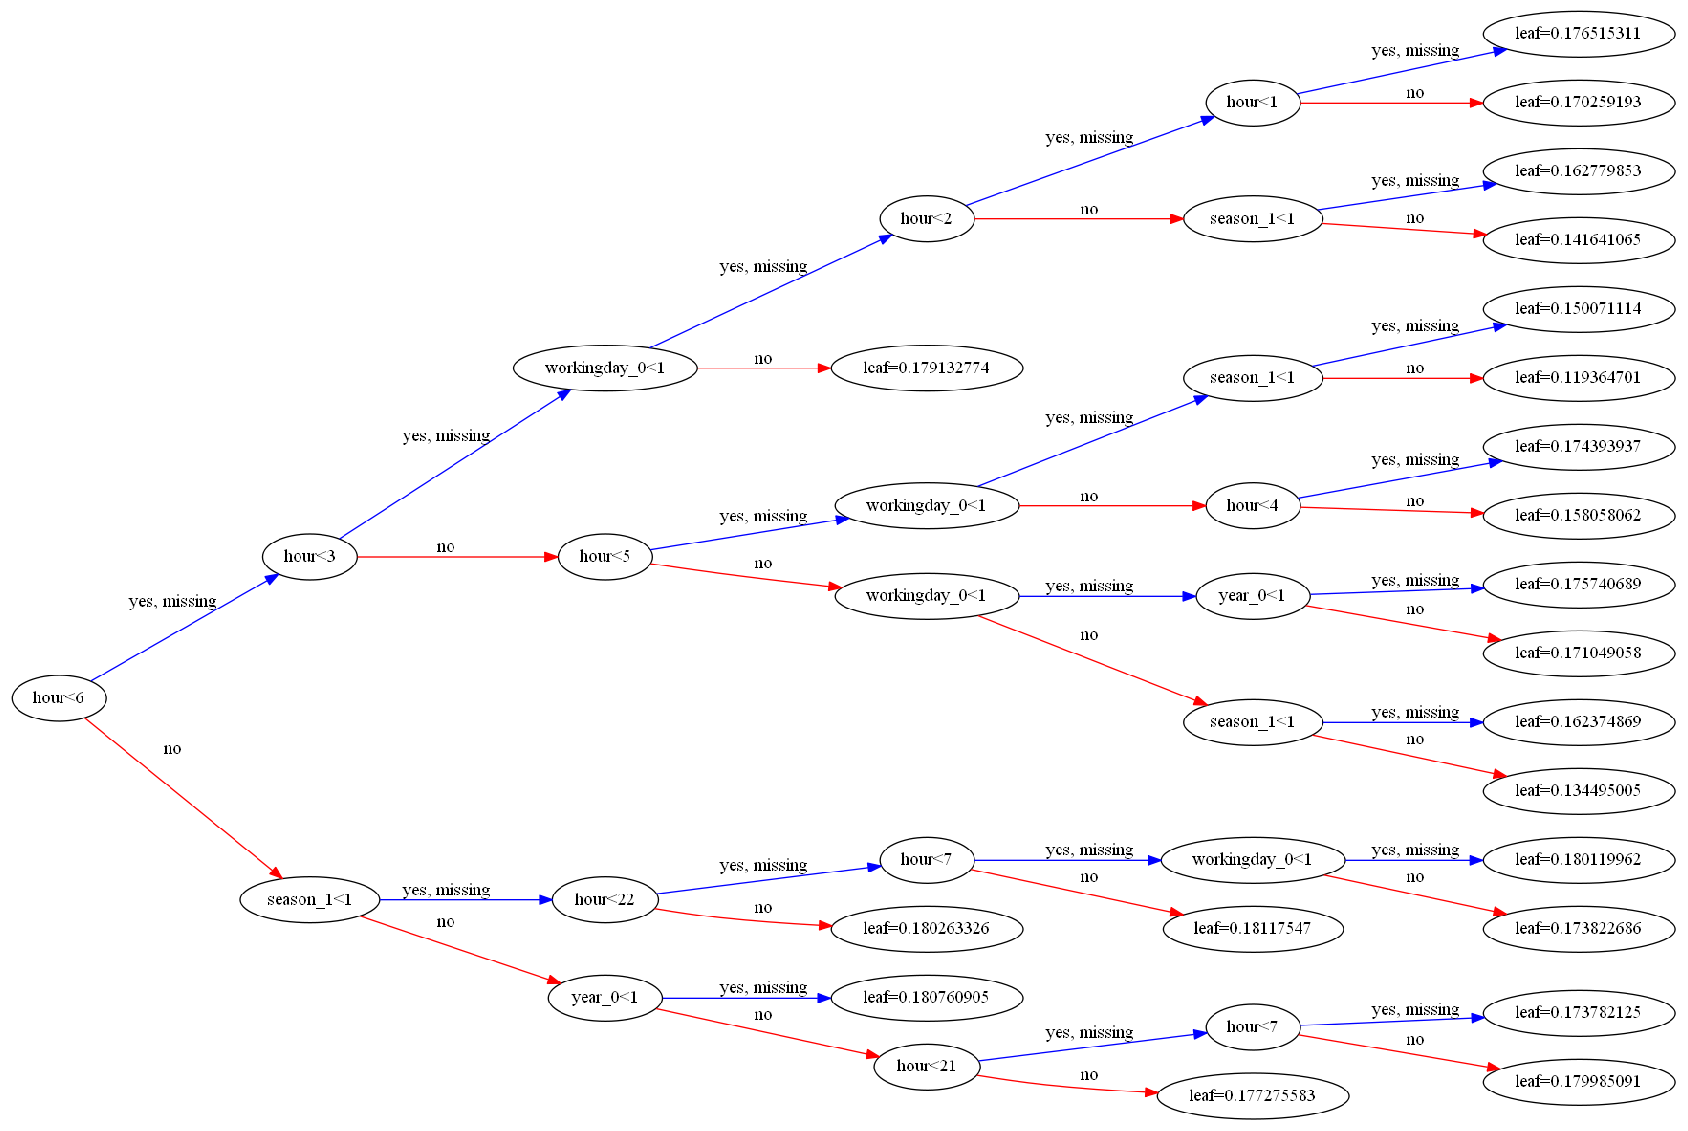

In [9]:
rcParams['figure.figsize'] = 30,30
xgb.plot_tree(xg_reg, num_trees = 1, rankdir = 'LR')
plt.show()

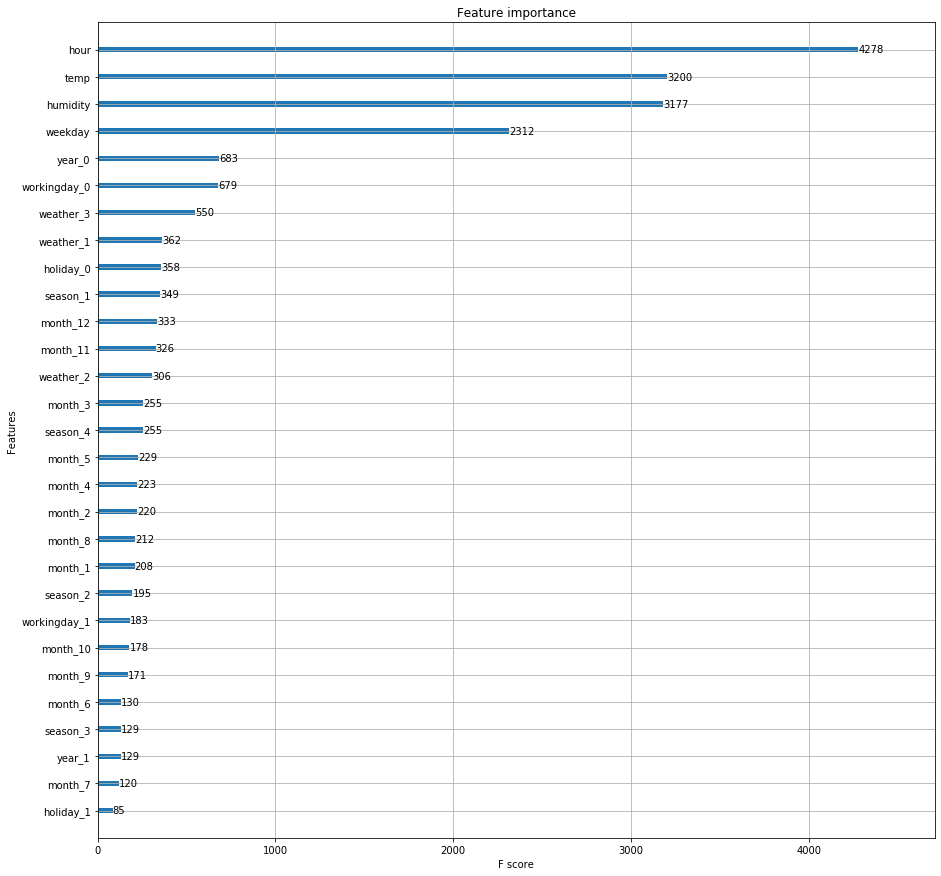

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_importance(xg_reg, ax=ax)
plt.show()

### Predictions

In [9]:
filename = 'test.csv' 
df_test = pd.read_csv(filename)

df_test.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

df_test['season'] = df_test.season.astype('category')
df_test['year'] = df_test.year.astype('category')
df_test['month'] = df_test.month.astype('category')
df_test['holiday'] = df_test.holiday.astype('category')
df_test['workingday'] = df_test.workingday.astype('category')
df_test['weather'] = df_test.weather.astype('category')

df_test = df_test.drop(['atemp', 'windspeed'], axis=1)
df_test = pd.get_dummies(df_test)

y_pred = xg_reg.predict(df_test)

for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

submission = pd.DataFrame()
submission['Id'] = range(y_pred.shape[0])
submission['Predicted'] = y_pred
submission.to_csv("submission_xgb.csv", index=False)